# Last-layer Low-Rank Kalman filter (LL-LRKF)
Kalman-filter-based low-rank Bayesian last-layer method.

In [1]:
import os
os.environ["KERAS_BACKEND"] = "jax"

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import jax
import keras
import optax
import numpy as np
import pandas as pd
import flax.linen as nn
import jax.numpy as jnp
import seaborn as sns
import matplotlib.pyplot as plt
from time import time
from tqdm import tqdm
from functools import partial
from jax.flatten_util import ravel_pytree

from rebayes_mini.methods import low_rank_filter_revised as lrkf
from rebayes_mini.methods import low_rank_last_layer as l3rkf

In [4]:
sns.set_palette("colorblind")

In [5]:
%config InlineBackend.figure_format = "retina"

## Load dataset

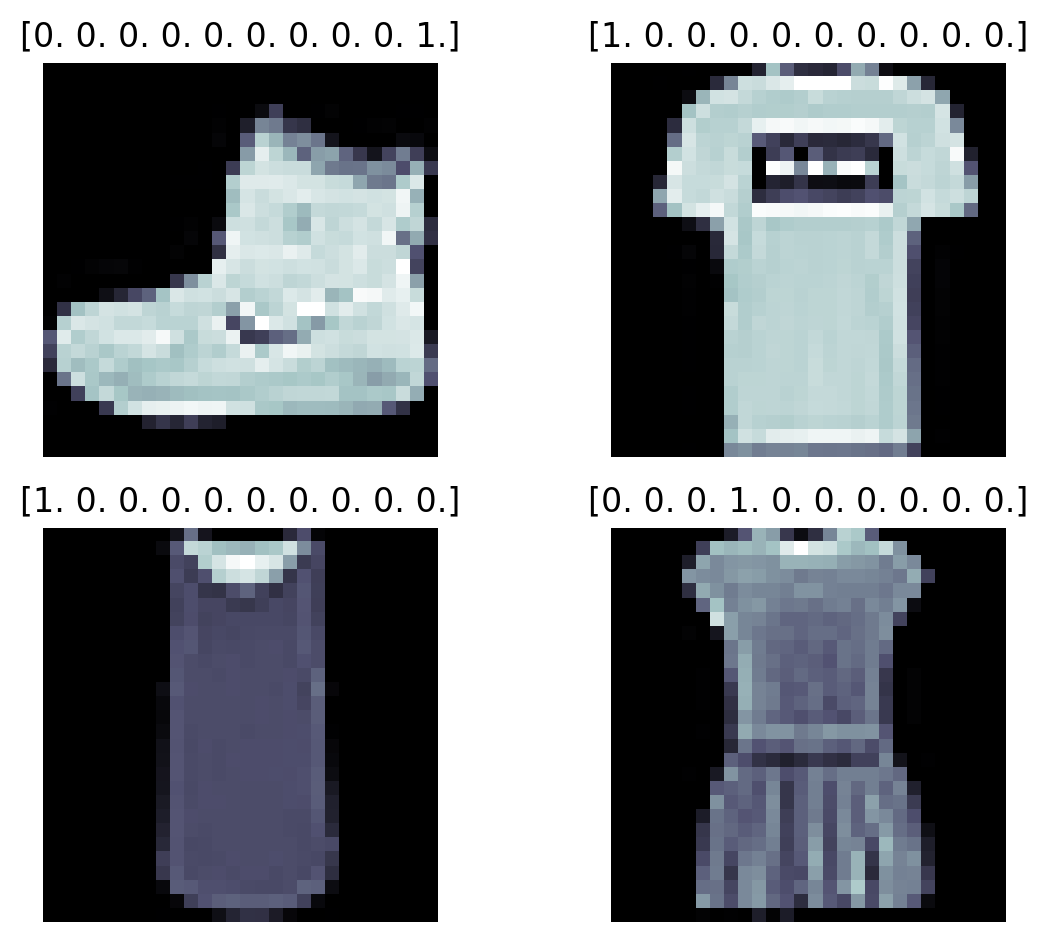

In [6]:
(X_train, y_train), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
# X_train = einops.rearrange(X_train, "s w h -> s (w h)") / 255
# X_test = einops.rearrange(X_test, "s w h -> s (w h)") / 255
X_train = X_train[..., None] / 255
X_test = X_test[..., None] / 255
y_train = jax.nn.one_hot(y_train, 10)
X_train = jnp.array(X_train)
fig, axs = plt.subplots(2, 2)
for i, ax in enumerate(axs.ravel()):
    ax.imshow(X_train[i], cmap="bone")
    ax.set_title(y_train[i])
    ax.axis("off")
plt.tight_layout()

## Train

In [7]:
X_eval = X_test[:5_000]
y_eval = y_test[:5_000]

In [8]:
class CNN(nn.Module):
    num_arms: int = 10

    @nn.compact
    def __call__(self, x):
        x = x if len(x.shape) > 3 else x[None, :]
        x = nn.Conv(features=6, kernel_size=(5, 5))(x)
        x = nn.relu(x)
        x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2), padding="VALID")
        x = nn.Conv(features=16, kernel_size=(5, 5), padding="VALID")(x)
        x = nn.relu(x)
        x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2), padding="VALID")
        x = x.reshape((x.shape[0], -1))  # Flatten
        x = nn.Dense(features=120)(x)
        x = nn.relu(x)
        x = nn.Dense(features=84)(x)
        x = nn.relu(x)
        # x = nn.Dense(20, name="last_layer")(x)
        # x = nn.relu(x)
        x = nn.Dense(10, name="last_layer")(x)
        # x = x - jax.nn.logsumexp(x)
        return x.squeeze()

model = CNN()

## Revised version

In [34]:
def callbackfn(bel_update, bel_pred, y, x, agent):
    """
    Compute test accuracy at every timestep
    """
    yhat = agent.mean_fn(bel_pred.mean, x)
    acc = y.argmax() == yhat.argmax()
    return acc

In [35]:
def mean_fn(params, x):
    eta = model.apply(params, x)
    return jax.nn.softmax(eta)

def cov_fn(mean, eps=0.1):
    return jnp.diag(mean) - jnp.outer(mean, mean) + jnp.eye(len(mean)) * eps

In [47]:
%%time
key = jax.random.PRNGKey(314)
model = CNN()
params = model.init(key, X_train[:100])


# agent = lrkf.MultinomialFilter(
#     model.apply,
#     dynamics_covariance=1e-4,
#     rank=10,
#     eps=0.1,
# )
# bel_init = agent.init_bel(params, cov=1.0)

agent = lrkf.LowRankCovarianceFilter(
    mean_fn,
    cov_fn,
    dynamics_covariance=0.01,
    rank=5,
)
bel_init = agent.init_bel(params, cov=1.0, low_rank_diag=True)

cfn = partial(callbackfn, agent=agent)
bel, hist_lrkf = agent.scan(bel_init, y_train, X_train, cfn)
hist_lrkf = np.array(hist_lrkf) * 1.0
bel = jax.block_until_ready(bel)

CPU times: user 9.78 s, sys: 110 ms, total: 9.89 s
Wall time: 21.3 s


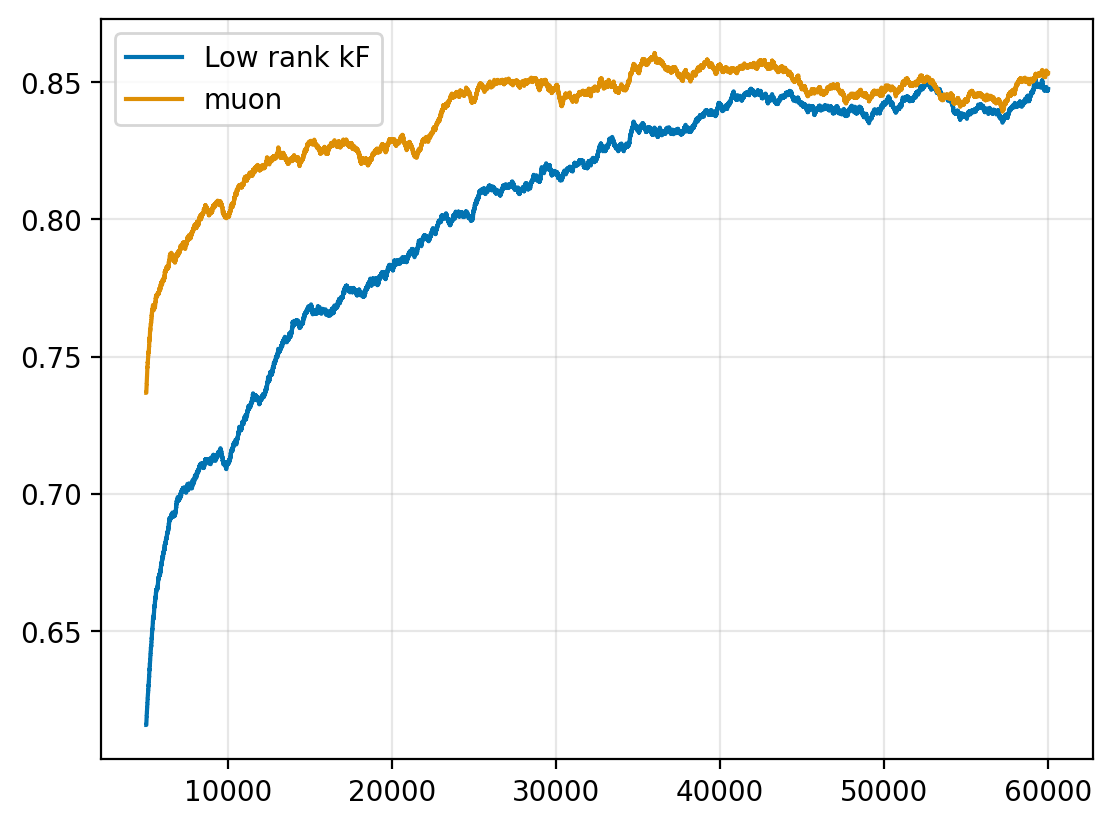

In [48]:
min_periods = 5000
pd.Series(hist_lrkf).rolling(5000, min_periods=min_periods).mean().plot(label="Low rank kF")
pd.Series(hist_muon).rolling(5000, min_periods=min_periods).mean().plot(label="muon")
plt.legend()
plt.grid(alpha=0.3)

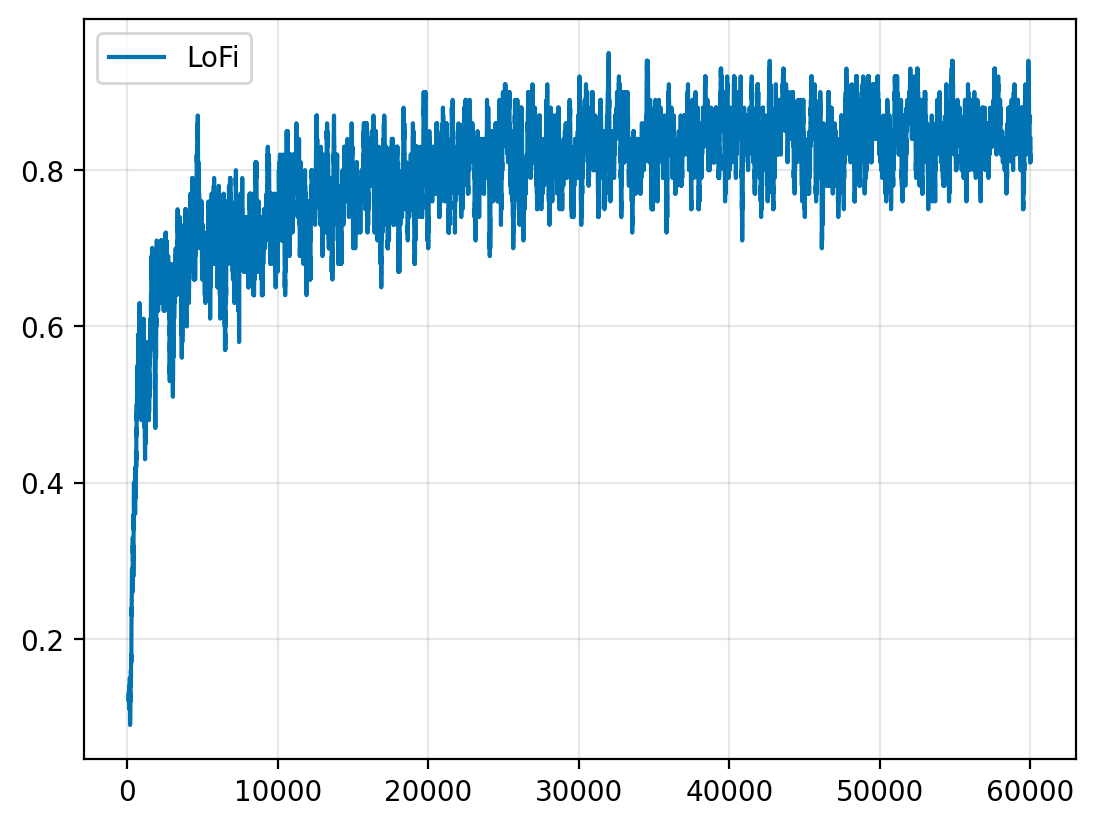

In [12]:
pd.Series(hist_lrkf).rolling(100).mean().plot(label="LoFi")
plt.grid(alpha=0.3)
plt.legend()

# Last-layer Low-rank Kalman filter (LL-LRKF)

In [52]:
def mean_fn(params, x):
    eta = model.apply(params, x)
    return jax.nn.softmax(eta)

def cov_fn(mean, eps=0.01):
    return jnp.diag(mean) - jnp.outer(mean, mean) + jnp.eye(len(mean)) * eps

In [53]:
agent = l3rkf.LowRankLastLayer(
    mean_fn, cov_fn, rank=5, dynamics_hidden=jnp.sqrt(1e-4), dynamics_last=jnp.sqrt(1e-4),
)
params = model.init(key, X_train[:100])

In [54]:
bel_init = agent.init_bel(params, cov_hidden=1.0, cov_last=1.0)
jax.tree.map(jnp.shape, bel_init)

LLLRState(mean_last=(850,), loading_last=(850, 850), mean_hidden=(60856,), loading_hidden=(5, 60856))

In [55]:
def callbackfn(bel_update, bel_pred, y, x, agent):
    """
    Compute test accuracy at every timestep
    """
    yhat = agent.mean_fn(bel_pred.mean_hidden, bel_pred.mean_last, x)
    acc = y.argmax() == yhat.argmax()
    return acc

In [56]:
%%time
cfn = partial(callbackfn, agent=agent)
bel_flow, hist = agent.scan(bel_init, y_train, X_train, cfn)
hist = jax.tree.map(np.array, hist)

CPU times: user 16.1 s, sys: 489 ms, total: 16.6 s
Wall time: 1min 16s


In [57]:
def callbackfn(bel_update, bel_pred, y, x, agent):
    """
    Compute test accuracy at every timestep
    """
    yhat = agent.mean_fn(bel_pred.mean_hidden, bel_pred.mean_last, x)
    acc = y.argmax() == yhat.argmax()
    return acc

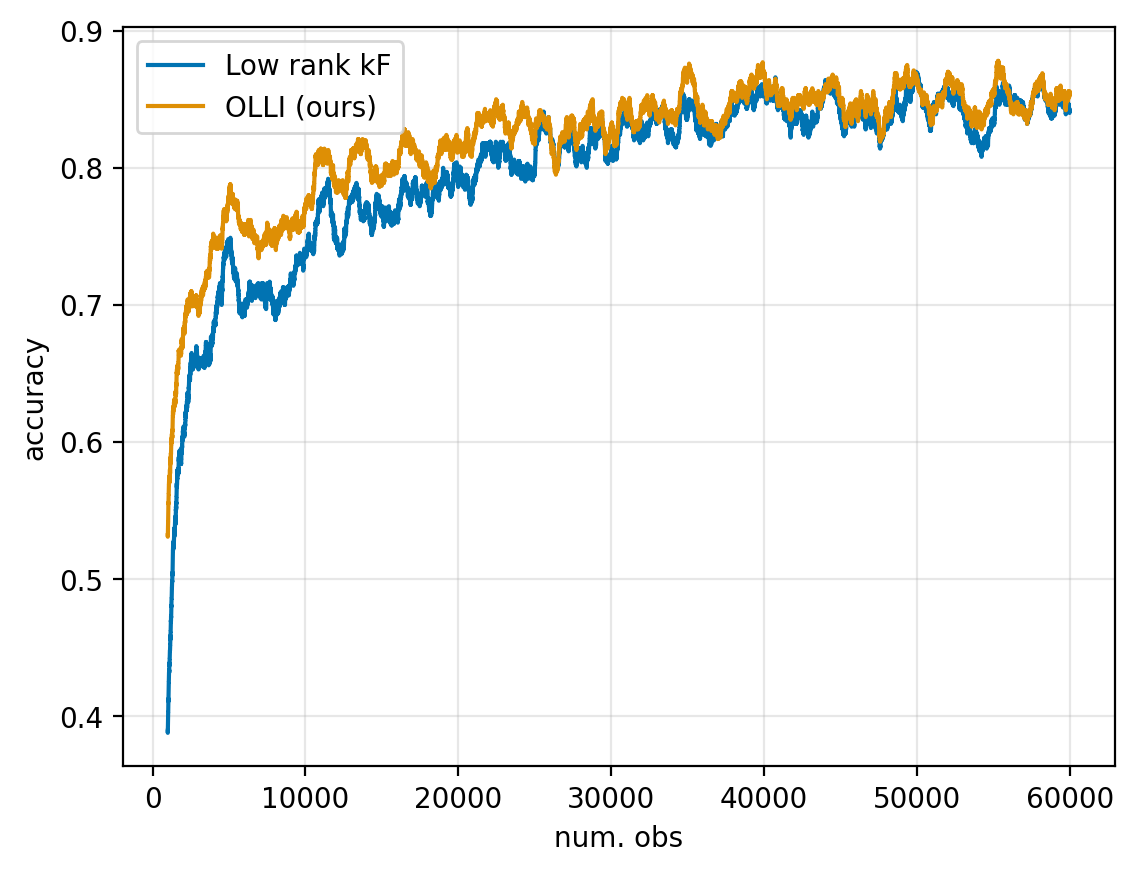

In [58]:
pd.Series(hist_lrkf).rolling(1000).mean().plot(label="Low rank kF")
pd.Series(hist).rolling(1000).mean().plot(label="OLLI (ours)")
plt.grid(alpha=0.3)
plt.ylabel("accuracy")
plt.xlabel("num. obs")
plt.legend()

## Muon Shampoo

In [20]:
from rebayes_mini.methods import replay_sgd

In [21]:
def callbackfn(bel_update, bel_pred, y, x, agent):
    """
    Compute test accuracy at every timestep
    """
    yhat = agent.apply_fn(bel_pred.params, x)
    acc = y.argmax() == yhat.argmax()
    return acc

In [22]:
yhat = model.apply(params, X_train[:10])

In [23]:
def lossfn(params, counter, X, y, fn):
    yhat = fn(params, X)
    loss = optax.losses.softmax_cross_entropy(yhat, y)
    return (loss * counter).sum() / counter.sum()

In [30]:
agent = replay_sgd.FifoSGD(
    model.apply,
    lossfn,
    tx=optax.contrib.muon(learning_rate=1e-3),
    buffer_size=1,
    dim_features=(28, 28, 1),
    dim_output=10
)

In [31]:
%%time
cfn = partial(callbackfn, agent=agent)
bel_init = agent.init_bel(params)
bel_muon, hist_muon = agent.scan(bel_init, y_train, X_train, cfn)
hist_muon = jax.tree.map(np.array, hist_muon)

CPU times: user 3.25 s, sys: 36.2 ms, total: 3.29 s
Wall time: 10.4 s


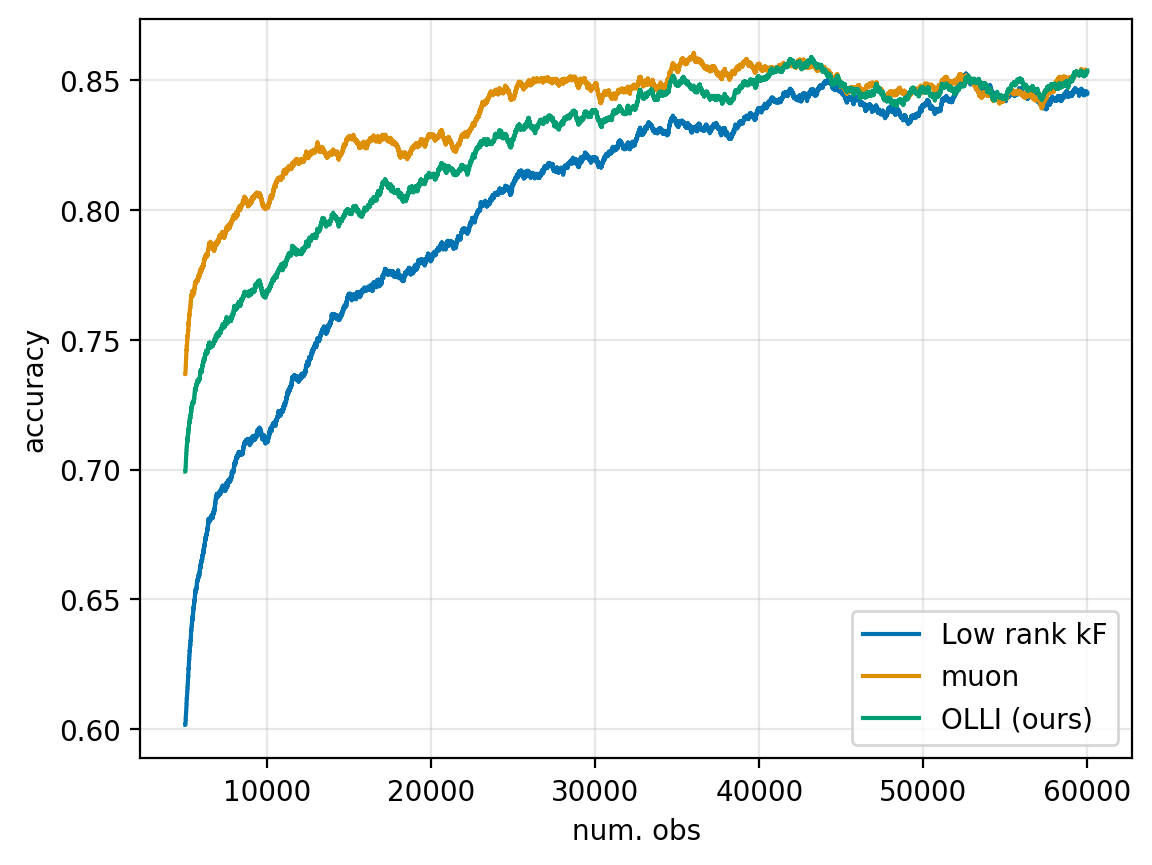

In [32]:
min_periods = 5000
pd.Series(hist_lrkf).rolling(5000, min_periods=min_periods).mean().plot(label="Low rank kF")
pd.Series(hist_muon).rolling(5000, min_periods=min_periods).mean().plot(label="muon")
pd.Series(hist).rolling(5000, min_periods=min_periods).mean().plot(label="OLLI (ours)")
plt.grid(alpha=0.3)
plt.ylabel("accuracy")
plt.xlabel("num. obs")
plt.legend()

## LoFi

## Multiple ranks

With constant full-rank inflation

In [138]:
key = jax.random.PRNGKey(3141)

In [147]:
%%time
ranks = [0, 1, 2, 5, 10, 20, 30, 50, 70, 100]
hist_all = {}
times_all = {}
params = model.init(key, X_train[:100])
for rank in ranks:
    print(rank, end="\r")

    agent = lrkf.LowRankCovarianceFilter(
        mean_fn,
        cov_fn,
        # dynamics_covariance=jnp.sqrt(1e-4),
        dynamics_covariance=0.001,
        rank=rank,
    )
    bel_init = agent.init_bel(params, cov=1.0, low_rank_diag=True)


    # agent = lrkf.MultinomialFilter(
    #     model.apply,
    #     dynamics_covariance=0.0,
    #     rank=rank,
    #     eps=0.1,
    # )
    # bel_init = agent.init_bel(params, cov=1e-4)

    time_init = time()
    cfn = partial(callbackfn, agent=agent)
    bel, hist_lrkf = agent.scan(bel_init, y_train[:20_000], X_train[:20_000], cfn)
    hist_lrkf = np.array(hist_lrkf) * 1.0
    times_all[rank] = time() - time_init
    hist_all[rank] = hist_lrkf

hist_all = pd.DataFrame(hist_all)

CPU times: user 1min 33s, sys: 1.46 s, total: 1min 35s
Wall time: 1min 36s


In [148]:
times_all

{0: 6.824768304824829,
 1: 8.278152704238892,
 2: 8.88245964050293,
 5: 8.18362832069397,
 10: 8.538988590240479,
 20: 8.829234600067139,
 30: 9.41533613204956,
 50: 10.752756595611572,
 70: 11.7045259475708,
 100: 14.935412168502808}

In [149]:
colors = plt.cm.viridis(jnp.linspace(0, 1, len(ranks)))

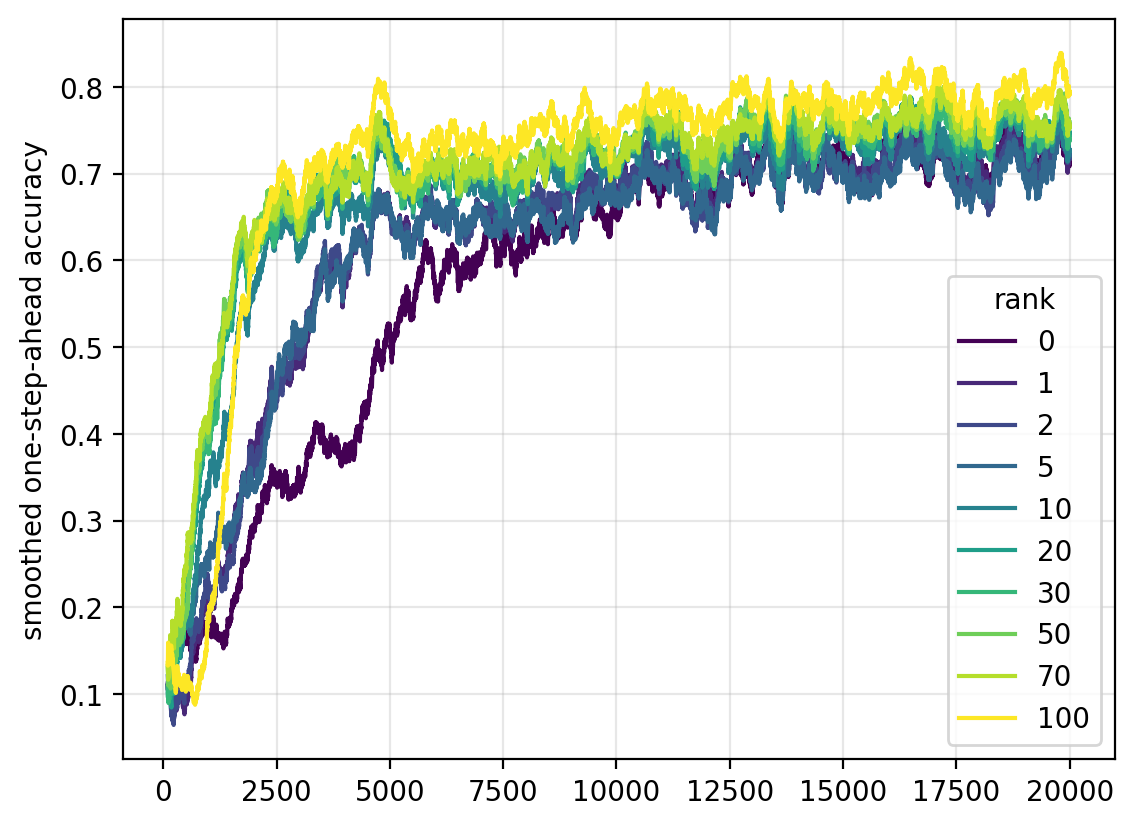

In [150]:
hist_all.ewm(min_periods=100, span=500).mean().plot(color=colors)
plt.ylabel("smoothed one-step-ahead accuracy")
plt.legend(title="rank")
plt.grid(alpha=0.3)